In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

**Chargement et exploration du dataset**

In [2]:
# --- Chargement du dataset complet ---
newsgroups = fetch_20newsgroups(subset='all',
                                remove=('headers', 'footers', 'quotes'))

# --- Création d'un DataFrame ---
df = pd.DataFrame({
    'text': newsgroups.data,
    'label': newsgroups.target
})

# --- Ajout des noms de classes ---
df['label_name'] = df['label'].apply(lambda x: newsgroups.target_names[x])

# --- Aperçu ---
print("Taille du dataset :", df.shape)
df.head()

Taille du dataset : (18846, 3)


,text,label,label_name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


Nombre de classes : 20
Liste des classes :
 ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


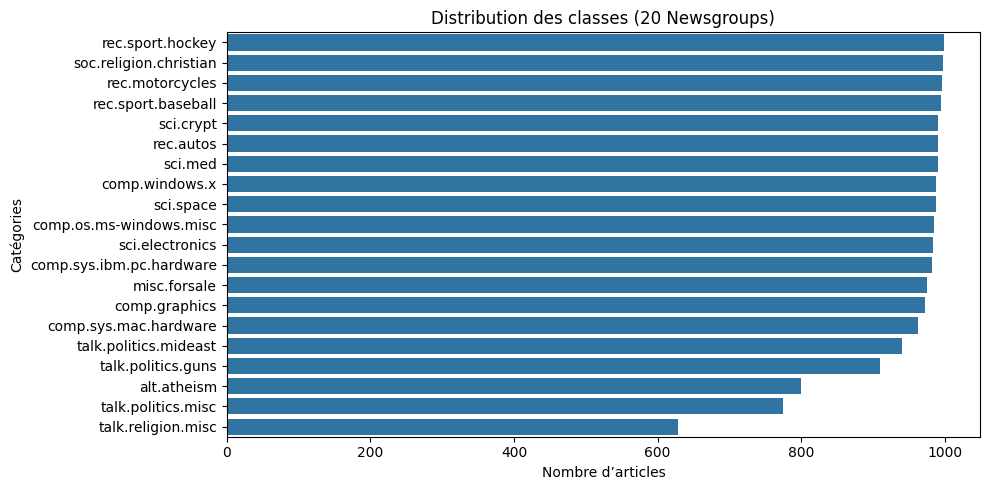


Longueur moyenne des textes : 181

--- Exemple d’article ---



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [3]:
# --- Nombre de classes ---
print("Nombre de classes :", len(newsgroups.target_names))
print("Liste des classes :\n", newsgroups.target_names)

# --- Distribution des classes ---
plt.figure(figsize=(10,5))
sns.countplot(y='label_name', data=df, order=df['label_name'].value_counts().index)
plt.title("Distribution des classes (20 Newsgroups)")
plt.xlabel("Nombre d’articles")
plt.ylabel("Catégories")
plt.tight_layout()
plt.show()

# --- Longueur moyenne des textes ---
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
print("\nLongueur moyenne des textes :", int(df['text_length'].mean()))

# --- Exemple de texte ---
print("\n--- Exemple d’article ---\n")
print(df.iloc[0]['text'][:1000])


In [4]:
# --- Split du dataset ---
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train : {len(train_df)} | Validation : {len(val_df)} | Test : {len(test_df)}")


Train : 15076 | Validation : 1885 | Test : 1885


**Prétraitement et Tokenization**

In [5]:
from transformers import BertTokenizerFast

# Initialisation du tokenizer BERT
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Exemple rapide
example = "Machine learning is transforming the world!"
tokens = tokenizer(example)
print(tokens)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': [101, 3698, 4083, 2003, 17903, 1996, 2088, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [6]:
# Fonction de nettoyage

import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # espaces multiples
    text = re.sub(r'http\S+', '', text)  # liens
    text = re.sub(r'[^a-zA-Z0-9.,!?;:\'\"()\[\] ]', '', text)  # caractères spéciaux inutiles
    return text.strip()

for df_part in [train_df, val_df, test_df]:
    df_part['text'] = df_part['text'].apply(clean_text)

In [7]:
# Encodage des labels

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['label_enc'] = label_encoder.fit_transform(train_df['label_name'])
val_df['label_enc'] = label_encoder.transform(val_df['label_name'])
test_df['label_enc'] = label_encoder.transform(test_df['label_name'])

num_labels = len(label_encoder.classes_)
print("Nombre de classes :", num_labels)
print("Exemple de mapping :", dict(zip(label_encoder.classes_[:5], label_encoder.transform(label_encoder.classes_[:5]))))

Nombre de classes : 20
Exemple de mapping : {'alt.atheism': np.int64(0), 'comp.graphics': np.int64(1), 'comp.os.ms-windows.misc': np.int64(2), 'comp.sys.ibm.pc.hardware': np.int64(3), 'comp.sys.mac.hardware': np.int64(4)}


In [8]:
import torch

# Paramètres du tokenizer
MAX_LEN = 256  # tu peux ajuster selon ta mémoire GPU

def tokenize_data_bert(texts, labels):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors='pt'
    )
    encodings['labels'] = torch.tensor(labels.values)
    return encodings

In [9]:
# Conversion en format PyTorch (Dataset & DataLoader)

import torch
from torch.utils.data import Dataset, DataLoader

class NewsGroupsDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [10]:
# --- Tokenization + Dataset + DataLoader pour BERT ---

# Tokenization BERT
train_encodings_bert = tokenize_data_bert(train_df['text'], train_df['label_enc'])
val_encodings_bert = tokenize_data_bert(val_df['text'], val_df['label_enc'])
test_encodings_bert = tokenize_data_bert(test_df['text'], test_df['label_enc'])

# Création des datasets PyTorch
train_dataset_bert = NewsGroupsDataset(train_encodings_bert)
val_dataset_bert = NewsGroupsDataset(val_encodings_bert)
test_dataset_bert = NewsGroupsDataset(test_encodings_bert)

# Création des DataLoaders
BATCH_SIZE = 16
train_loader_bert = DataLoader(train_dataset_bert, batch_size=BATCH_SIZE, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=BATCH_SIZE)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=BATCH_SIZE)

print("Nombre de batches (train) :", len(train_loader_bert))

Nombre de batches (train) : 943


In [11]:
# test sur un batch

batch = next(iter(train_loader_bert))
print({k: v.shape for k, v in batch.items()})

{'input_ids': torch.Size([16, 256]), 'token_type_ids': torch.Size([16, 256]), 'attention_mask': torch.Size([16, 256]), 'labels': torch.Size([16])}


**Fine-tuning BERT avec PyTorch**

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from torch.optim import AdamW

# Choix du device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

Using device: cuda


In [13]:
# Chargement du modèle BERT pour classification
num_labels = len(label_encoder.classes_)
model_bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
)
model_bert.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Définir l’optimiseur et la loss

In [14]:
from torch.optim import AdamW
from torch import nn
from transformers import get_linear_schedule_with_warmup

# Optimiseur
optimizer = AdamW(model_bert.parameters(), lr=3e-5)  # BERT recommande souvent 2e-5 à 5e-5

# Loss
criterion = nn.CrossEntropyLoss()  # mono-label → CrossEntropyLoss

# Scheduler (optionnel mais conseillé)
num_epochs = 6
total_steps = len(train_loader_bert) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Boucle d’entraînement

In [15]:
for epoch in range(num_epochs):
    model_bert.train()
    train_loss = 0
    for batch in tqdm(train_loader_bert, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_bert)
    print(f"\nEpoch {epoch+1} — Average Training Loss: {avg_train_loss:.4f}")

Training Epoch 1: 100%|██████████| 943/943 [10:30<00:00,  1.50it/s]



Epoch 1 — Average Training Loss: 1.3248


Training Epoch 2: 100%|██████████| 943/943 [10:31<00:00,  1.49it/s]



Epoch 2 — Average Training Loss: 0.6956


Training Epoch 3: 100%|██████████| 943/943 [10:31<00:00,  1.49it/s]



Epoch 3 — Average Training Loss: 0.4319


Training Epoch 4: 100%|██████████| 943/943 [10:31<00:00,  1.49it/s]



Epoch 4 — Average Training Loss: 0.2704


Training Epoch 5: 100%|██████████| 943/943 [10:31<00:00,  1.49it/s]



Epoch 5 — Average Training Loss: 0.1756


Training Epoch 6: 100%|██████████| 943/943 [10:32<00:00,  1.49it/s]


Epoch 6 — Average Training Loss: 0.1364


**Évaluation sur la validation set**

In [16]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import torch

model_bert.eval()
val_labels = []
val_preds = []

with torch.no_grad():
    for batch in tqdm(val_loader_bert, desc="Validation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())

acc = accuracy_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds, average='macro')

print(f"\n Validation Accuracy: {acc:.4f} — F1 Score (macro): {f1:.4f}")


Validation: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]


 Validation Accuracy: 0.7660 — F1 Score (macro): 0.7609


Testing: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]



✅ Test Accuracy: 0.7708
✅ Test F1 Score (macro): 0.7648

📊 Classification Report :

                          precision    recall  f1-score   support

             alt.atheism       0.64      0.53      0.58        80
           comp.graphics       0.78      0.75      0.76        97
 comp.os.ms-windows.misc       0.78      0.73      0.76        98
comp.sys.ibm.pc.hardware       0.72      0.78      0.75        98
   comp.sys.mac.hardware       0.78      0.75      0.76        97
          comp.windows.x       0.89      0.84      0.86        99
            misc.forsale       0.94      0.74      0.83        98
               rec.autos       0.52      0.85      0.65        99
         rec.motorcycles       0.86      0.71      0.78       100
      rec.sport.baseball       0.87      0.82      0.84        99
        rec.sport.hockey       0.92      0.96      0.94       100
               sci.crypt       0.86      0.78      0.81        99
         sci.electronics       0.80      0.81      0.80 

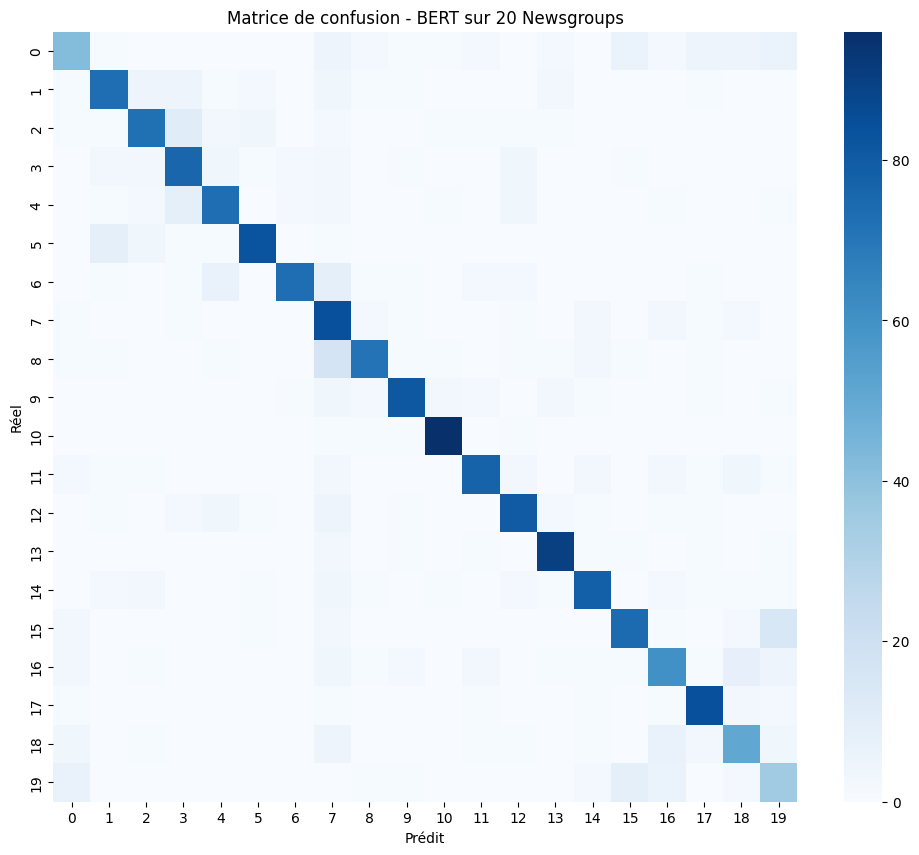


🔍 Exemples de prédictions :

Texte: You've asked a toughie of a question. There are many different drugs which are used for chemotherapy. The overall purpose of chemotherapy (don't worry about the spelling. Some of these crazy medical w...
Label réel: sci.med — Label prédit: sci.med

Texte: The commercial uses of a transportation system between alreadysettled andcivilized areas are obvious. Spaceflight is NOT in this position. The correct analogy is not with aviation of the '30's, but th...
Label réel: sci.space — Label prédit: sci.space

Texte: "Put not your trust in princes" is the Biblical proverb. The modern analog is governments. At the time of the founding of the US, the idea that citizens had rights above those of the government was no...
Label réel: talk.politics.guns — Label prédit: alt.atheism

Texte: I find these to be intriguing remarks. Could you give us a bit more explanation here? For example, which religion is antisemitic, and which aesthetic?...
Label réel: alt.atheis

In [17]:
# --- Étape 4 : Évaluation finale sur le test set ---

model_bert.eval()  # mode évaluation
test_labels = []
test_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader_bert, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

# --- Calcul des métriques ---
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(test_labels, test_preds)
f1_macro = f1_score(test_labels, test_preds, average='macro')

print(f"\n✅ Test Accuracy: {accuracy:.4f}")
print(f"✅ Test F1 Score (macro): {f1_macro:.4f}")

# --- Rapport détaillé par classe ---
print("\n📊 Classification Report :\n")
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))

# --- Matrice de confusion ---
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Matrice de confusion - BERT sur 20 Newsgroups")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

# --- Affichage de quelques prédictions ---
print("\n🔍 Exemples de prédictions :\n")
for i in range(10):
    real_label = label_encoder.inverse_transform([test_labels[i]])[0]
    pred_label = label_encoder.inverse_transform([test_preds[i]])[0]
    text_preview = test_df.iloc[i]['text'][:200].replace('\n', ' ')
    print(f"Texte: {text_preview}...")
    print(f"Label réel: {real_label} — Label prédit: {pred_label}\n")
